In this Jupyter Notebook we run the experiments of Section 6.3 without the pre-Cheeger regularisation; i.e., considering the problem over the $L^2$-space.

First of all, we have to import the required libraries as well as the data.

In [5]:
from keras.datasets import mnist
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random
from CF_NeuralNetwork import FFNN
from CF_NeuralNetwork_PC import FFNNPC

#Load the training set and normalize it
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train=X_train/X_train.sum(axis=(1,2))[:,None,None]
X_train=np.reshape(X_train,(np.size(X_train,0),28*28))
X_test=X_test/X_test.sum(axis=(1,2))[:,None,None]
X_test=np.reshape(X_test,(np.size(X_test,0),28*28))
D_train=np.loadtxt('MNIST_D_train', delimiter=',')
D_test=np.loadtxt('MNIST_D_test', delimiter=',')
Y_train=D_train
Y_test=D_test

x_Train_t=Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_Train_t=Variable(torch.from_numpy(Y_train).float(), requires_grad=False)
x_Test_t=Variable(torch.from_numpy(X_test).float(), requires_grad=False)
y_Test_t=Variable(torch.from_numpy(Y_test).float(), requires_grad=False)

We will first define the $L^2$-norm and inner product, as well as the loss functions.

In [6]:
def L2norm(inp,model):
    fs=0.0
    pred=model(inp)
    predt=torch.transpose(pred,0,1)
    ts=pred.size(dim=0)
    fs=1/ts*torch.mm(predt,pred)
    res=torch.sqrt(fs)
    return res.reshape(-1)

def EulerLagrangeProduct(x_inp,y_inp,model_f,model_G):
    S1=0
    ts=x_inp.size(dim=0)
    f_pred=model_f(x_inp)
    y_inp=y_inp.reshape(ts,1)
    fdiff=f_pred-y_inp
    G_pred=model_G(x_inp)
    G_pred_t=torch.transpose(G_pred,0,1)
    S1=1/ts*torch.mm(G_pred_t,fdiff)
    val=S1
    S2S=L2norm(x_inp,model_G)
    val=val/S2S
    return val

def LossFunction_f(x_inp,y_inp,model_f,model_G):
    prod=EulerLagrangeProduct(x_inp,y_inp,model_f,model_G)
    loss=torch.abs(prod)
    return loss

def LossFunction_G(x_inp,y_inp,model_f,model_G):
    prod=EulerLagrangeProduct(x_inp,y_inp,model_f,model_G)
    loss=-1.0*torch.abs(prod)
    return loss

def my_rel_loss(output,target):
    loss=torch.abs(output-target)
    loss=loss/target
    loss=torch.mean(loss)
    return loss

We start with the choices $N_\Xi =1$ and $N_\Theta=2$.

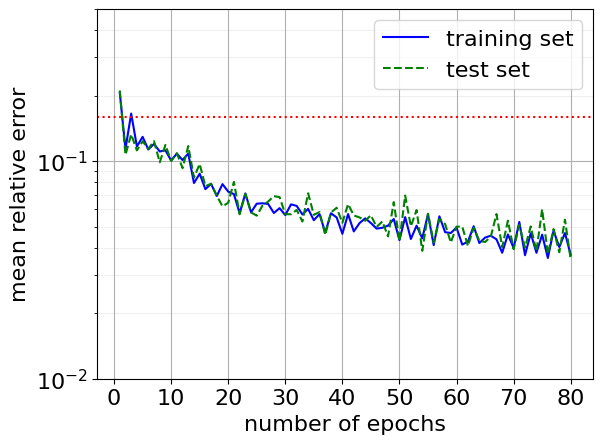

In [7]:
#Set up the neural network based on npot potentials
nd=x_Train_t.size(dim=1)
npot=2**7
model_f=FFNN(nd,npot,non_trainable=False)
model_G=FFNN(nd,npot,non_trainable=False)
optimizer_f = torch.optim.Adam(model_f.parameters())
optimizer_G = torch.optim.Adam(model_G.parameters())

epochs_f=2
epochs_G=1
loops=80
batch_size = 64

epoch_MRE=[]
epoch_MRE_Test=[]
epoch_list=[]

for loopc in range(loops):
    for epochs_G_c in range(epochs_G):
        permutation = torch.randperm(x_Train_t.size()[0])
        for i in range(0,x_Train_t.size()[0], batch_size):
            optimizer_G.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
            loss=LossFunction_G(batch_x,batch_y,model_f,model_G)
            loss.backward()
            optimizer_G.step()
    for epochs_f_c in range(epochs_f):
        permutation = torch.randperm(x_Train_t.size()[0])
        acc_MRE=0
        acc_Loss=0
        counter=0
        for i in range(0,x_Train_t.size()[0], batch_size):
            optimizer_f.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
            loss=LossFunction_f(batch_x,batch_y,model_f,model_G)
            loss.backward()
            optimizer_f.step()
            y_pred=model_f(batch_x)
            y_pred=y_pred.reshape(-1)
            acc_MRE+=my_rel_loss(y_pred,batch_y)
            acc_Loss+=loss
            counter+=1
    y_pred_test=model_f(x_Test_t)
    y_pred_test=y_pred_test.reshape(-1)
    MRE_Test=my_rel_loss(y_pred_test,y_Test_t)
    epoch_MRE_Test.append(MRE_Test.detach().numpy())
    MRE=acc_MRE/counter
    epoch_MRE.append(MRE.detach().numpy())
    epoch_list.append(loopc+1)

epoch_MRE=np.array(epoch_MRE)
epoch_MRE_Test=np.array(epoch_MRE_Test)
counter=np.array(epoch_list)

#Plot the results
fig, ax = plt.subplots()
ax.set_ylim([0.01, 0.5])
plt.xlabel('number of epochs',fontsize=16)
plt.ylabel('mean relative error',fontsize=16)
plot_1a, =ax.semilogy(counter,epoch_MRE,color='blue',label='training set')
plot_1b, =ax.semilogy(counter,epoch_MRE_Test,'--',color='green',label='test set')
plt.axhline(y = 0.1594, color = 'r', linestyle = ':')
ax.legend(handles=[plot_1a,plot_1b],loc='upper right',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()

Next we set $N_\Xi =2$ and $N_\Theta=1$.

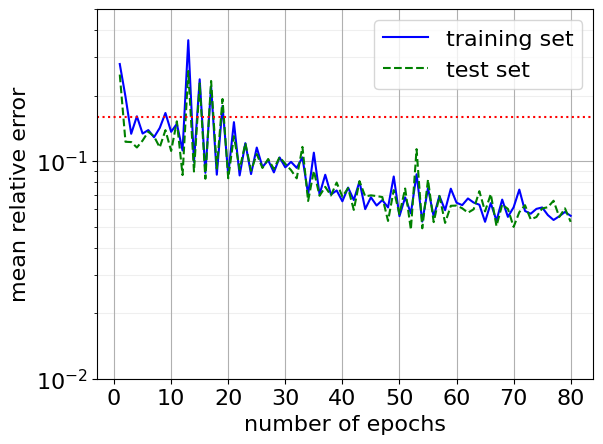

In [8]:
#Set up the neural network based on npot potentials
nd=x_Train_t.size(dim=1)
npot=2**7
model_f=FFNN(nd,npot,non_trainable=False)
model_G=FFNN(nd,npot,non_trainable=False)
optimizer_f = torch.optim.Adam(model_f.parameters())
optimizer_G = torch.optim.Adam(model_G.parameters())

epochs_f=1
epochs_G=2
loops=80
batch_size = 64

epoch_MRE=[]
epoch_MRE_Test=[]
epoch_list=[]

for loopc in range(loops):
    for epochs_G_c in range(epochs_G):
        permutation = torch.randperm(x_Train_t.size()[0])
        for i in range(0,x_Train_t.size()[0], batch_size):
            optimizer_G.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
            loss=LossFunction_G(batch_x,batch_y,model_f,model_G)
            loss.backward()
            optimizer_G.step()
    for epochs_f_c in range(epochs_f):
        permutation = torch.randperm(x_Train_t.size()[0])
        acc_MRE=0
        acc_Loss=0
        counter=0
        for i in range(0,x_Train_t.size()[0], batch_size):
            optimizer_f.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
            loss=LossFunction_f(batch_x,batch_y,model_f,model_G)
            loss.backward()
            optimizer_f.step()
            y_pred=model_f(batch_x)
            y_pred=y_pred.reshape(-1)
            acc_MRE+=my_rel_loss(y_pred,batch_y)
            acc_Loss+=loss
            counter+=1
    y_pred_test=model_f(x_Test_t)
    y_pred_test=y_pred_test.reshape(-1)
    MRE_Test=my_rel_loss(y_pred_test,y_Test_t)
    epoch_MRE_Test.append(MRE_Test.detach().numpy())
    MRE=acc_MRE/counter
    epoch_MRE.append(MRE.detach().numpy())
    epoch_list.append(loopc+1)

epoch_MRE=np.array(epoch_MRE)
epoch_MRE_Test=np.array(epoch_MRE_Test)
counter=np.array(epoch_list)

#Plot the results
fig, ax = plt.subplots()
ax.set_ylim([0.01, 0.5])
plt.xlabel('number of epochs',fontsize=16)
plt.ylabel('mean relative error',fontsize=16)
plot_1a, =ax.semilogy(counter,epoch_MRE,color='blue',label='training set')
plot_1b, =ax.semilogy(counter,epoch_MRE_Test,'--',color='green',label='test set')
plt.axhline(y = 0.1594, color = 'r', linestyle = ':')
ax.legend(handles=[plot_1a,plot_1b],loc='upper right',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()